# Training environment information

In [1]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           15Gi       3.6Gi        10Gi        14Mi       1.2Gi        11Gi
Swap:            0B          0B          0B


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4da11d72-97d4-858f-ade5-7da69e2bf57a)


In [3]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz


In [4]:
!lscpu | grep 'Core(s) per socket:'

Core(s) per socket:              2


In [5]:
!nvidia-smi

Sat Jan 21 09:49:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |   1436MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


Preventing disconnect from Google Colab notebook:
Right-click on the connect button and paste the code to the console of the UI:


```
function ClickConnect(){
    console.log("Clicked on connect button");
    document.querySelector("colab-connect-button").click() 
 }
 setInterval(ClickConnect,60000)
```

# Setup

In [7]:
!pip install fastai==2.5.3 -q
!pip freeze

anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1666191106763/work/dist
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1666850859330/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1659291887007/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1649463573192/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1656355450470/work
blis==0.7.9
catalogue==2.0.8
certifi==2022.12.7
cffi @ file:///home/conda/feedstock_root/build_artifacts/cffi_1666754707314/work
charset-normalizer==2.1.1
click==8.1.3
confection==0.0.3
contourpy==1.0.6
cycler==0.11

In [8]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *
import sys

In [9]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [10]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  # copy external libraries to /content
  #! unzip LiBEIS.zip
  #! unzip ml4measurement.zip
  #! unzip datasets.zip

In [11]:
import yaml
config_file = '../config/config-train_single.yaml'
if IN_COLAB :
  config_file = 'config_colab.yaml'


#Read the configuration
with open(config_file) as cfg_file:
    config = yaml.load(stream = cfg_file, Loader = yaml.FullLoader)

classification_results_out = config['classification_results_out']
pca_scatter_plots_out = config['pca_scatter_plots_out']

In [12]:
# Load EB_ML python libraries
# The following libraries are used in this notebook and should be installed in your local machine before running this notebook.
# eb_colab_utils.py
# eb_ml_battery_lib.py
# eb_ml_utils.py

# path to load external *.py files used in this notebook
# Note: in Google Colab virtual machine you shoud copy the files in "/content" folder after BEFORE running this notebook's cell
external_python_file_path="/home/studio-lab-user/code"
sys.path.append(external_python_file_path)

from ml4measurement.eb_ml_utils import score_model,build_learner,build_and_train_learner,save_model_weights,build_data_loader
from ml4measurement.eb_ml_colab_utils import get_root_path,copy_model_to_google_drive
from ml4measurement.eb_ml_battery_lib import generate_image_files_from_measure_table,generate_EIS_images_for_experiment


# Training Configuration

In [13]:
config

{'freq_table_src': '../data/frequencies.csv',
 'meas_table_src': '../datasets/EIS-vs-SOC-jun2022/impedance.csv',
 'models_path': '../data/models',
 'root_images_path': '../data/images',
 'root_test_images_path': '../data/test_images',
 'results_path': '../results',
 'model_metrics': 'accuracy',
 'battery_id_field': 'BATTERY_ID',
 'measure_id_field': 'MEASURE_ID',
 'frequency_id_field': 'FREQUENCY_ID',
 'soc_field': 'SOC',
 'impedance_field': 'IMPEDANCE_VALUE',
 'classification_results_out': '../results/classification-results.txt',
 'pca_scatter_plots_out': '../results/scatter-plots.svg',
 'working_folder': '/home/studio-lab-user/',
 'soc_list': ['100',
  '090',
  '080',
  '070',
  '060',
  '050',
  '040',
  '030',
  '020',
  '010'],
 'all_batteries': ['02_4',
  '02_5',
  '02_6',
  '02_7',
  '02_8',
  '02_9',
  '03_4',
  '03_5',
  '03_6',
  '03_7',
  '03_8',
  '03_9',
  '05_3',
  '05_4',
  '05_5',
  '05_6',
  '05_7'],
 'test_measure_list': ['06_04', '06_05', '06_06', '06_07', '06_08'],


In [14]:
#configuration dictionary

# Map the worming folder to Google Drive is running in Google Colab environment
config['ROOT_DIR'] = get_root_path(config['working_folder'])


NOT running on COLAB


## Train Single

In [15]:
from itertools import product
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from LiBEIS.code.utilities import read_measurement_table,FeatureExtractionMode,DataNormaliser,get_patterns

#Note: Some pattern_extraction_mode values are disabled to avoid  exceeding 
# the computation time limit of Code Ocean 
pattern_extraction_modes =\
    [#FeatureExtractionMode(mode = 'module'),
     #FeatureExtractionMode(mode = 'phase'),
     FeatureExtractionMode(mode = 'bode'),
     #FeatureExtractionMode(mode = 'real'),
     #FeatureExtractionMode(mode = 'imag'),
     FeatureExtractionMode(mode = 'real+imag')]



# Normalization is not compatible with data augmentation
normalization_modes =\
    [DataNormaliser(name = 'None', model = None),
     #DataNormaliser(name = 'MinMax', model = MinMaxScaler),
     #DataNormaliser(name = 'Z-score', model = StandardScaler)
    ]

data_agumentation_factors = [10]

#Generate a full factorial plan by pattern_extraction_modes x classifiers
factorial_plan = product(pattern_extraction_modes, normalization_modes,data_agumentation_factors)

factorial_plan = list(factorial_plan)
num_experiments = len(factorial_plan)

In [16]:

# Load dataset using LiBEIS 
_, meas_table_wide, battery_id_col_name, freq_id_col_name, impedance_col_name, measure_id_col_name, soc_col_name = read_measurement_table(config_file)

indices = np.arange(meas_table_wide.shape[0]).astype(np.uint)


/home/studio-lab-user/soc-estimation-jan23/code/LiBEIS/code/utilities.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  meas_table_wide = meas_table_tall.pivot(primary_key, freq_id_col_name)


In [17]:
meas_table_wide

MEASURE_ID  SOC BATTERY_ID     IMPEDANCE_VALUE  \
FREQUENCY_ID                                              0   
0                  02_4   10          2  0.117933-0.006453j   
1                  02_4   20          2  0.108914-0.004577j   
2                  02_4   30          2  0.105084-0.003881j   
3                  02_4   40          2  0.104545-0.003870j   
4                  02_4   50          2  0.103768-0.004256j   
..                  ...  ...        ...                 ...   
235                06_8   60          6  0.105475-0.005807j   
236                06_8   70          6  0.104604-0.006193j   
237                06_8   80          6  0.103358-0.005761j   
238                06_8   90          6  0.103680-0.005234j   
239                06_8  100          6  0.102012-0.004807j   

                                                                          \
FREQUENCY_ID                   1                   2                   3   
0             0.115688-0.005226j  0.114258-0.004235j  0.113243-0.003809j   
1             0.107390-0.003691j  0.106296-0.002381j  0.105806-0.002027j   
2             0.103869-0.003199j  0.103098-0.002013j  0.102843-0.001713j   
3             0.103324-0.002926j  0.102673-0.002098j  0.102103-0.001555j   
4             0.102449-0.003355j  0.101666-0.002424j  0.101108-0.001858j   
..                           ...                 ...                 ...   
235           0.103037-0.005163j  0.101439-0.003260j  0.100950-0.002266j   
236           0.102764-0.004643j  0.101474-0.003235j  0.100668-0.002506j   
237           0.101491-0.004417j  0.100160-0.003028j  0.099628-0.002222j   
238           0.102111-0.004055j  0.100888-0.002762j  0.100350-0.002017j   
239           0.101459-0.002807j  0.100853-0.002208j  0.100232-0.001664j   

                                                                          \
FREQUENCY_ID                   4                   5                   6   
0             0.111026-0.004652j  0.109057-0.005699j  0.106340-0.006653j   
1             0.104751-0.002257j  0.103965-0.002888j  0.102727-0.004009j   
2             0.101968-0.001720j  0.101440-0.002340j  0.100473-0.003114j   
3             0.101310-0.001838j  0.100783-0.002343j  0.100185-0.002937j   
4             0.099993-0.001833j  0.099596-0.002300j  0.099106-0.002856j   
..                           ...                 ...                 ...   
235           0.099744-0.002003j  0.099114-0.002131j  0.098424-0.002288j   
236           0.099592-0.001932j  0.098702-0.002253j  0.098120-0.002294j   
237           0.098459-0.001881j  0.097915-0.001947j  0.097327-0.002187j   
238           0.099374-0.001809j  0.098816-0.001959j  0.098189-0.002165j   
239           0.099547-0.001447j  0.099191-0.001673j  0.098627-0.002070j   

                                                                          \
FREQUENCY_ID                   7                   8                   9   
0             0.101733-0.007526j  0.097836-0.007710j  0.094492-0.007356j   
1             0.099835-0.005825j  0.096654-0.006610j  0.093300-0.006884j   
2             0.098450-0.004741j  0.095612-0.006006j  0.092412-0.006553j   
3             0.097745-0.004520j  0.095411-0.005965j  0.092198-0.006490j   
4             0.096909-0.004247j  0.094556-0.005593j  0.091448-0.006259j   
..                           ...                 ...                 ...   
235           0.096977-0.003218j  0.095176-0.004172j  0.092986-0.004747j   
236           0.096754-0.003253j  0.095009-0.003961j  0.092899-0.004740j   
237           0.096023-0.002886j  0.094421-0.003751j  0.092544-0.004401j   
238           0.096783-0.003066j  0.095252-0.004004j  0.093130-0.004682j   
239           0.097250-0.003201j  0.095518-0.004299j  0.093175-0.004895j   

                                                                          \
FREQUENCY_ID                  10                  11                  12   
0             0.090119-0.006749j  0.086891-0.006165j  0.084373-0.005057j  

In [18]:
cross_validation_list = config['cross_validation_list']
cross_validation_experiment_names = config['cross_validation_experiment_names']
train_measures_list = config['all_batteries']
experiment_name_prefix= config['experiment_name_prefix']
generate_images=config['generate_images']
measure_id_col_name= config['measure_id_field']
soc_col_name=config['soc_field']
n_epochs=config['n_epochs']
root_image_files_path = config['root_images_path']
test_measures_list = config['test_measure_list']

Running experiment 1 of 2
battery data acquisitions for training and validation: 
['02_4', '02_5', '02_6', '02_7', '02_8', '02_9', '03_4', '03_5', '03_6', '03_7', '03_8', '03_9', '05_3', '05_4', '05_5', '05_6', '05_7']
battery data acquisitions for test: 
['06_04', '06_05', '06_06', '06_07', '06_08']
model name: Paper_MES_v2_single__Exp_0
Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying Reg

Valley: 4.79e-04


epoch,train_loss,valid_loss,accuracy,time
0,2.885044,1.483063,0.411765,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.867885,1.153483,0.533333,00:07
1,1.731582,0.993762,0.596078,00:07
2,1.556722,0.850353,0.645098,00:07
3,1.399988,0.743919,0.698039,00:07
4,1.292691,0.654528,0.715686,00:07
5,1.150316,0.583150,0.756863,00:07
6,1.014489,0.534639,0.776471,00:07
7,0.914497,0.494565,0.796078,00:07
8,0.822600,0.430646,0.841176,00:07
9,0.770664,0.401364,0.835294,00:07


saved filename: Paper_MES_v2_single__Exp_0_1674294950.893247_SAVED.pth
Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying RegexLabeller gives
      80
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(8))


Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILB

[[48  0  0  0  0  0  0  0  0  0]
 [ 0 49  2  3  1  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  1  0 35  5  1  0  0  0  0]
 [ 0  0  0 16 32  1  0  0  0  0]
 [ 0  0  1  1  1 50  0  0  0  1]
 [ 0  0  0  0  0  0 51  2  0  0]
 [ 0  0  0  0  0  0  0 45  7  1]
 [ 0  0  0  0  0  0  0 11 41  1]
 [ 0  0  0  0  0  0  0  0  3 43]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.89090909 0.03636364 0.05454545 0.01818182 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.02380952 0.         0.83333333 0.11904762 0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.32653061 0.65306122 0.02040816
  0.         0.         0.         0.        ]
 [0.         0.         0.01851852 0.01851852 0.01851852 0.92592593
  0.         0.         0.         0.01851852]
 [0

learn.validate()


Model accuracy: 0.88
learn.get_preds()


Running experiment 2 of 2
battery data acquisitions for training and validation: 
['02_4', '02_5', '02_6', '02_7', '02_8', '02_9', '03_4', '03_5', '03_6', '03_7', '03_8', '03_9', '05_3', '05_4', '05_5', '05_6', '05_7']
battery data acquisitions for test: 
['06_04', '06_05', '06_06', '06_07', '06_08']
model name: Paper_MES_v2_single__Exp_1
Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying Reg

Valley: 1.74e-03


epoch,train_loss,valid_loss,accuracy,time
0,2.620818,1.719295,0.449020,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.760600,0.873397,0.654902,00:07
1,1.444401,0.669897,0.739216,00:07
2,1.218693,0.526635,0.803922,00:07
3,1.102918,0.475701,0.817647,00:07
4,0.970792,0.409126,0.827451,00:07
5,0.841023,0.430497,0.831373,00:07
6,0.754526,0.410648,0.841176,00:07
7,0.727881,0.343001,0.884314,00:07
8,0.685692,0.394696,0.843137,00:07
9,0.637932,0.270366,0.898039,00:07


saved filename: Paper_MES_v2_single__Exp_1_1674295349.009869_SAVED.pth
Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying RegexLabeller gives
      80
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(8))


Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILB

[[48  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  0  2 35  4  1  0  0  0  0]
 [ 0  0  0  8 39  2  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 46  7  0]
 [ 0  0  0  0  0  0  0  7 46  0]
 [ 0  0  0  0  0  0  0  0  0 46]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.04761905 0.83333333 0.0952381  0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.16326531 0.79591837 0.04081633
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.       

learn.validate()


Model accuracy: 0.94
learn.get_preds()


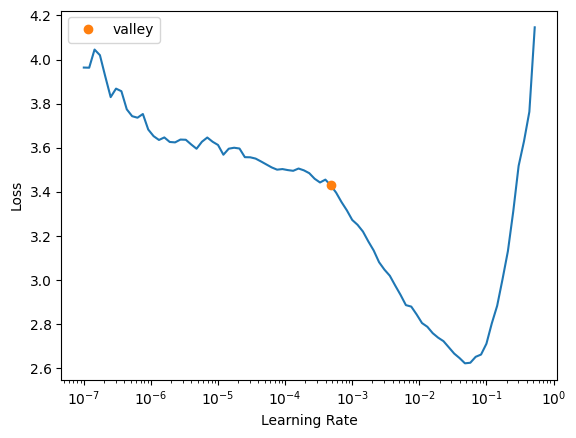

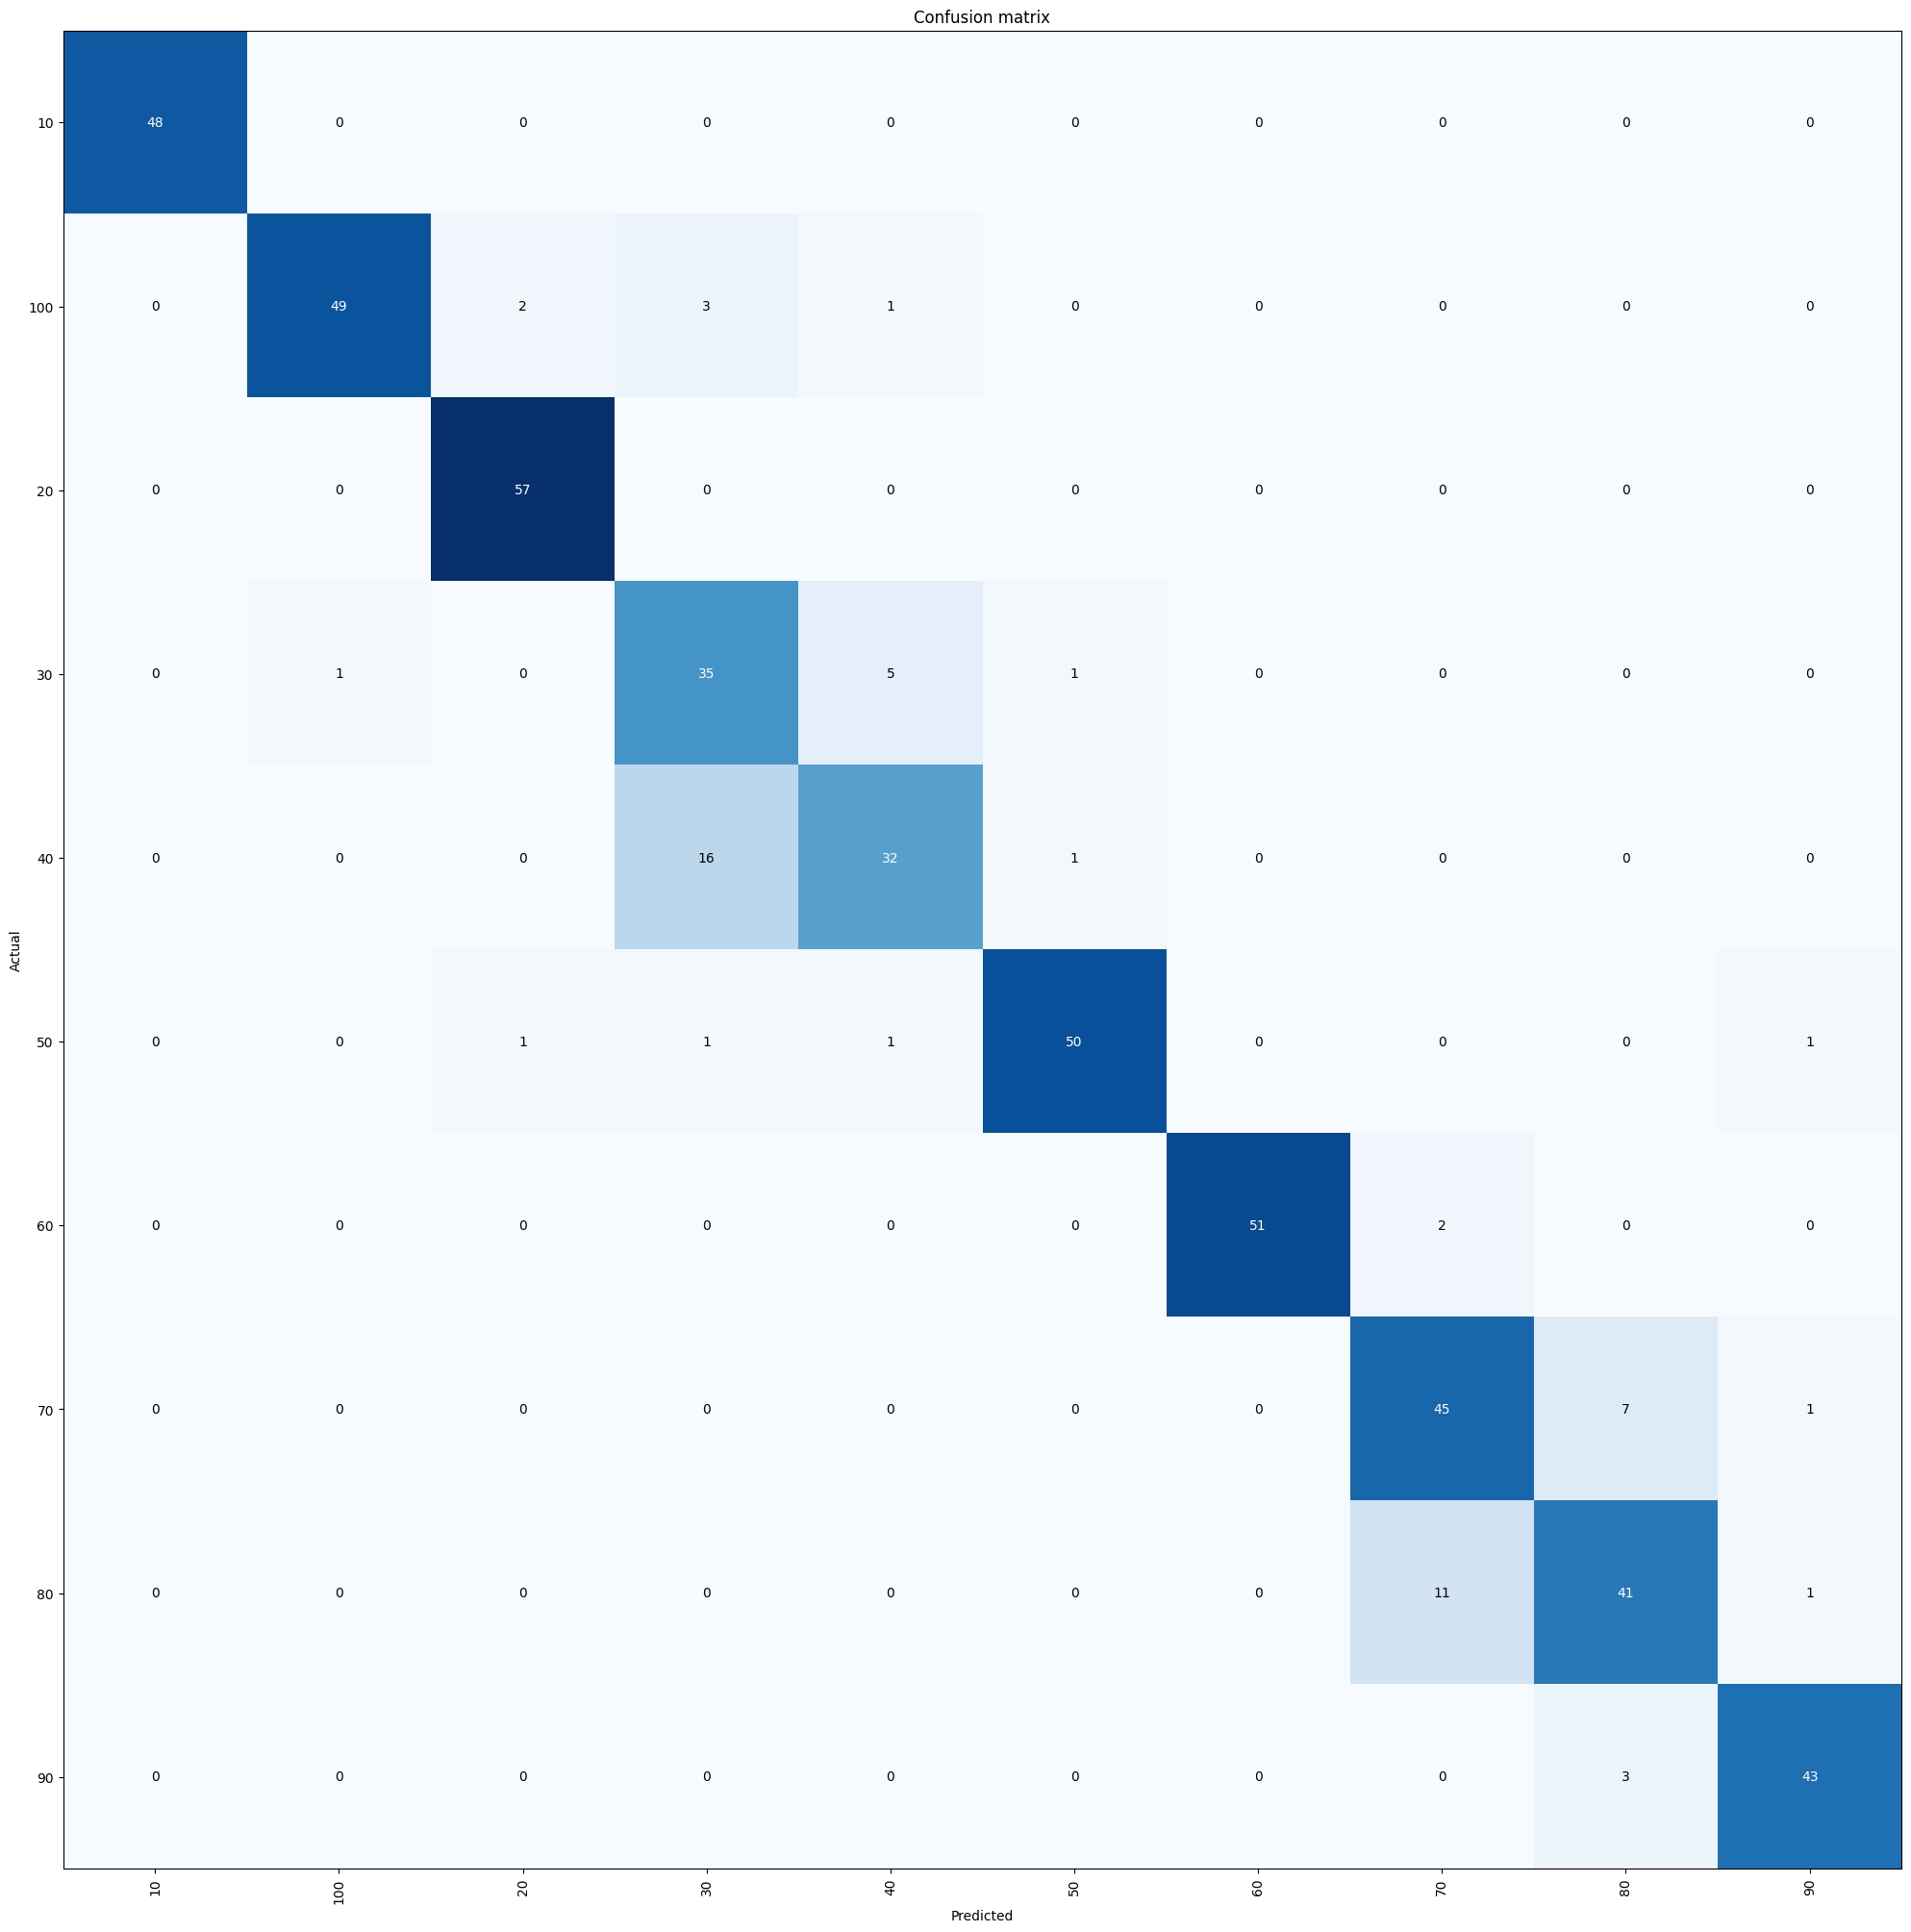

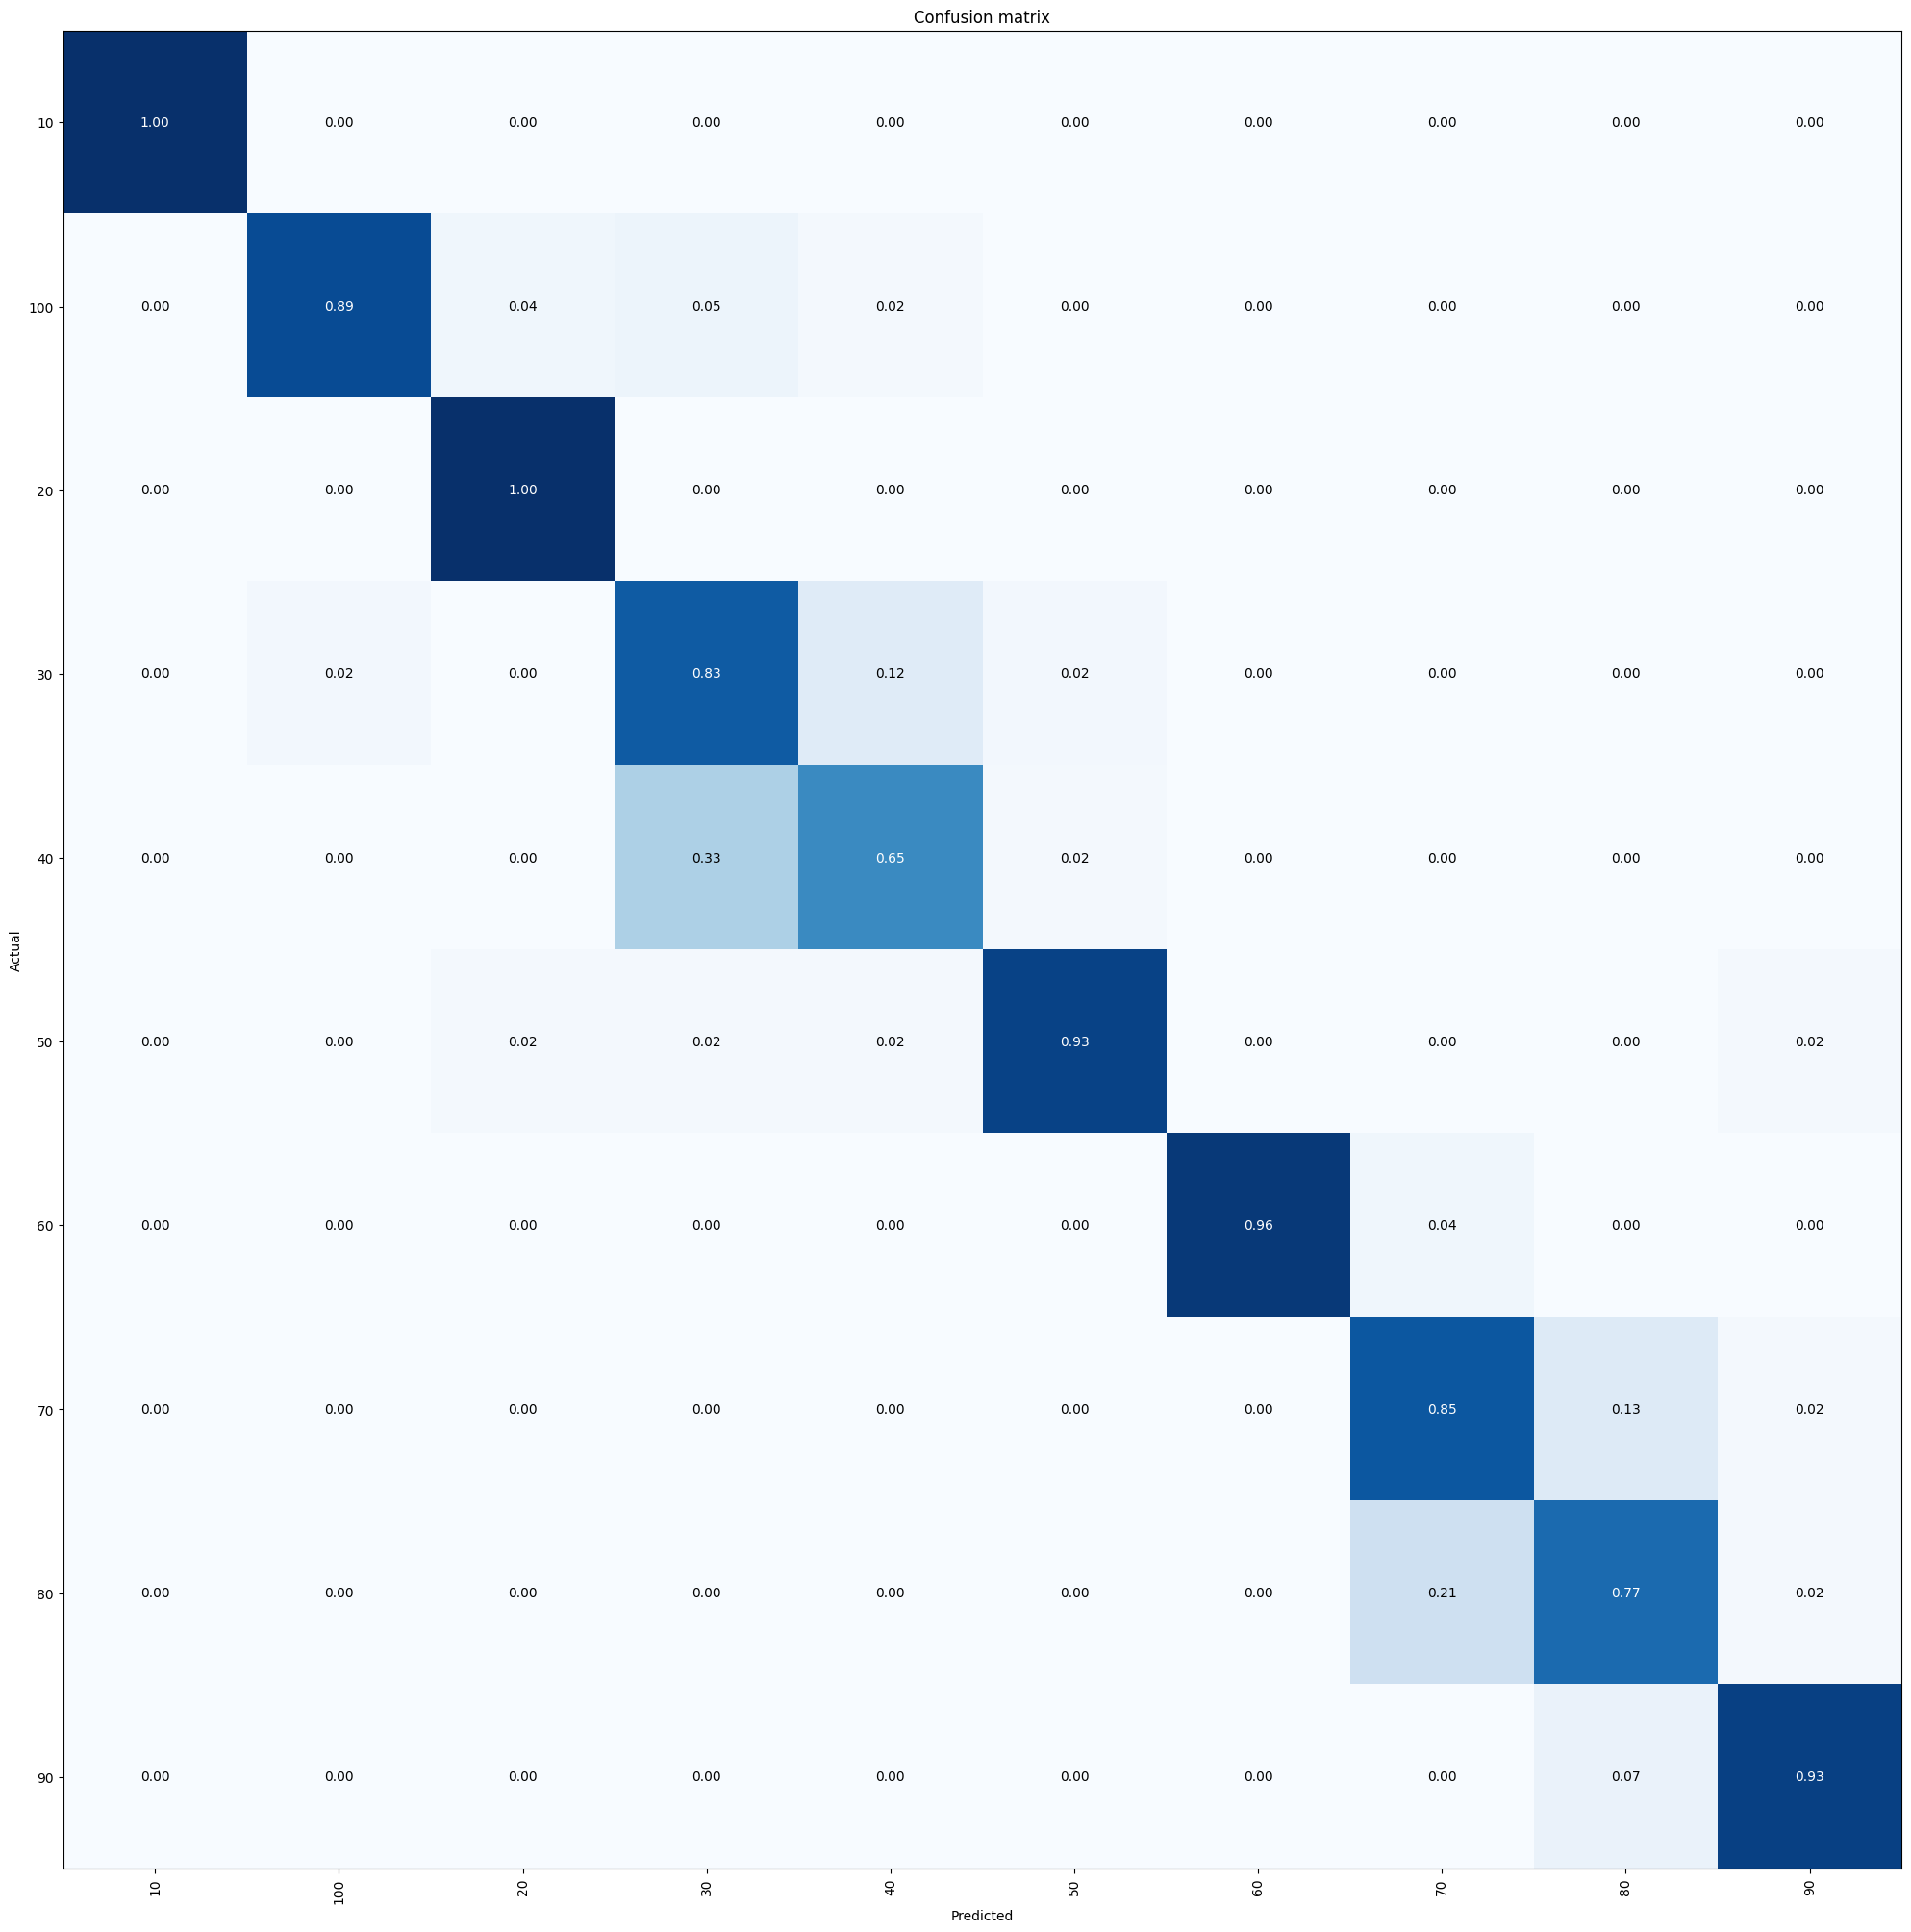

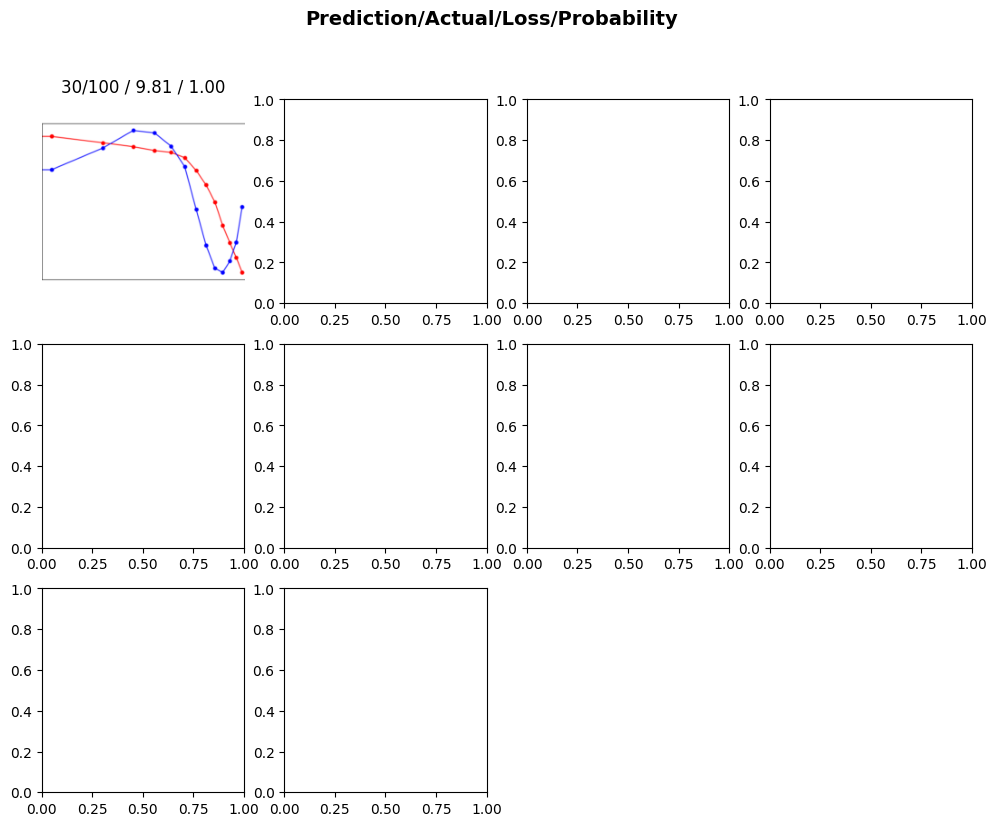

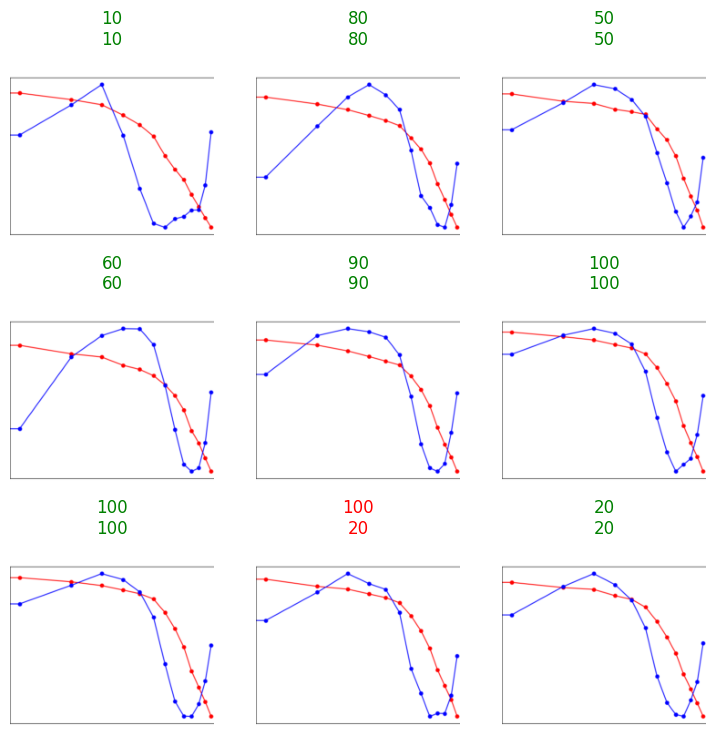

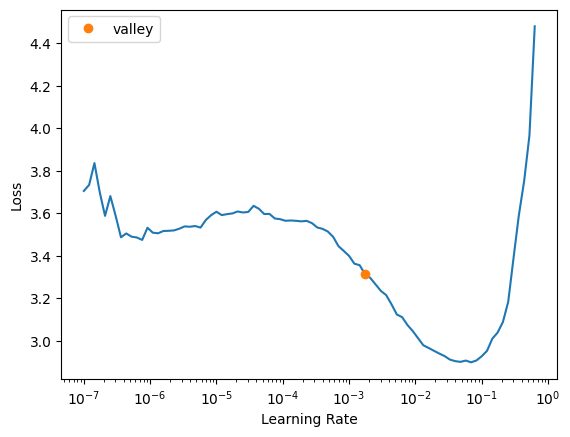

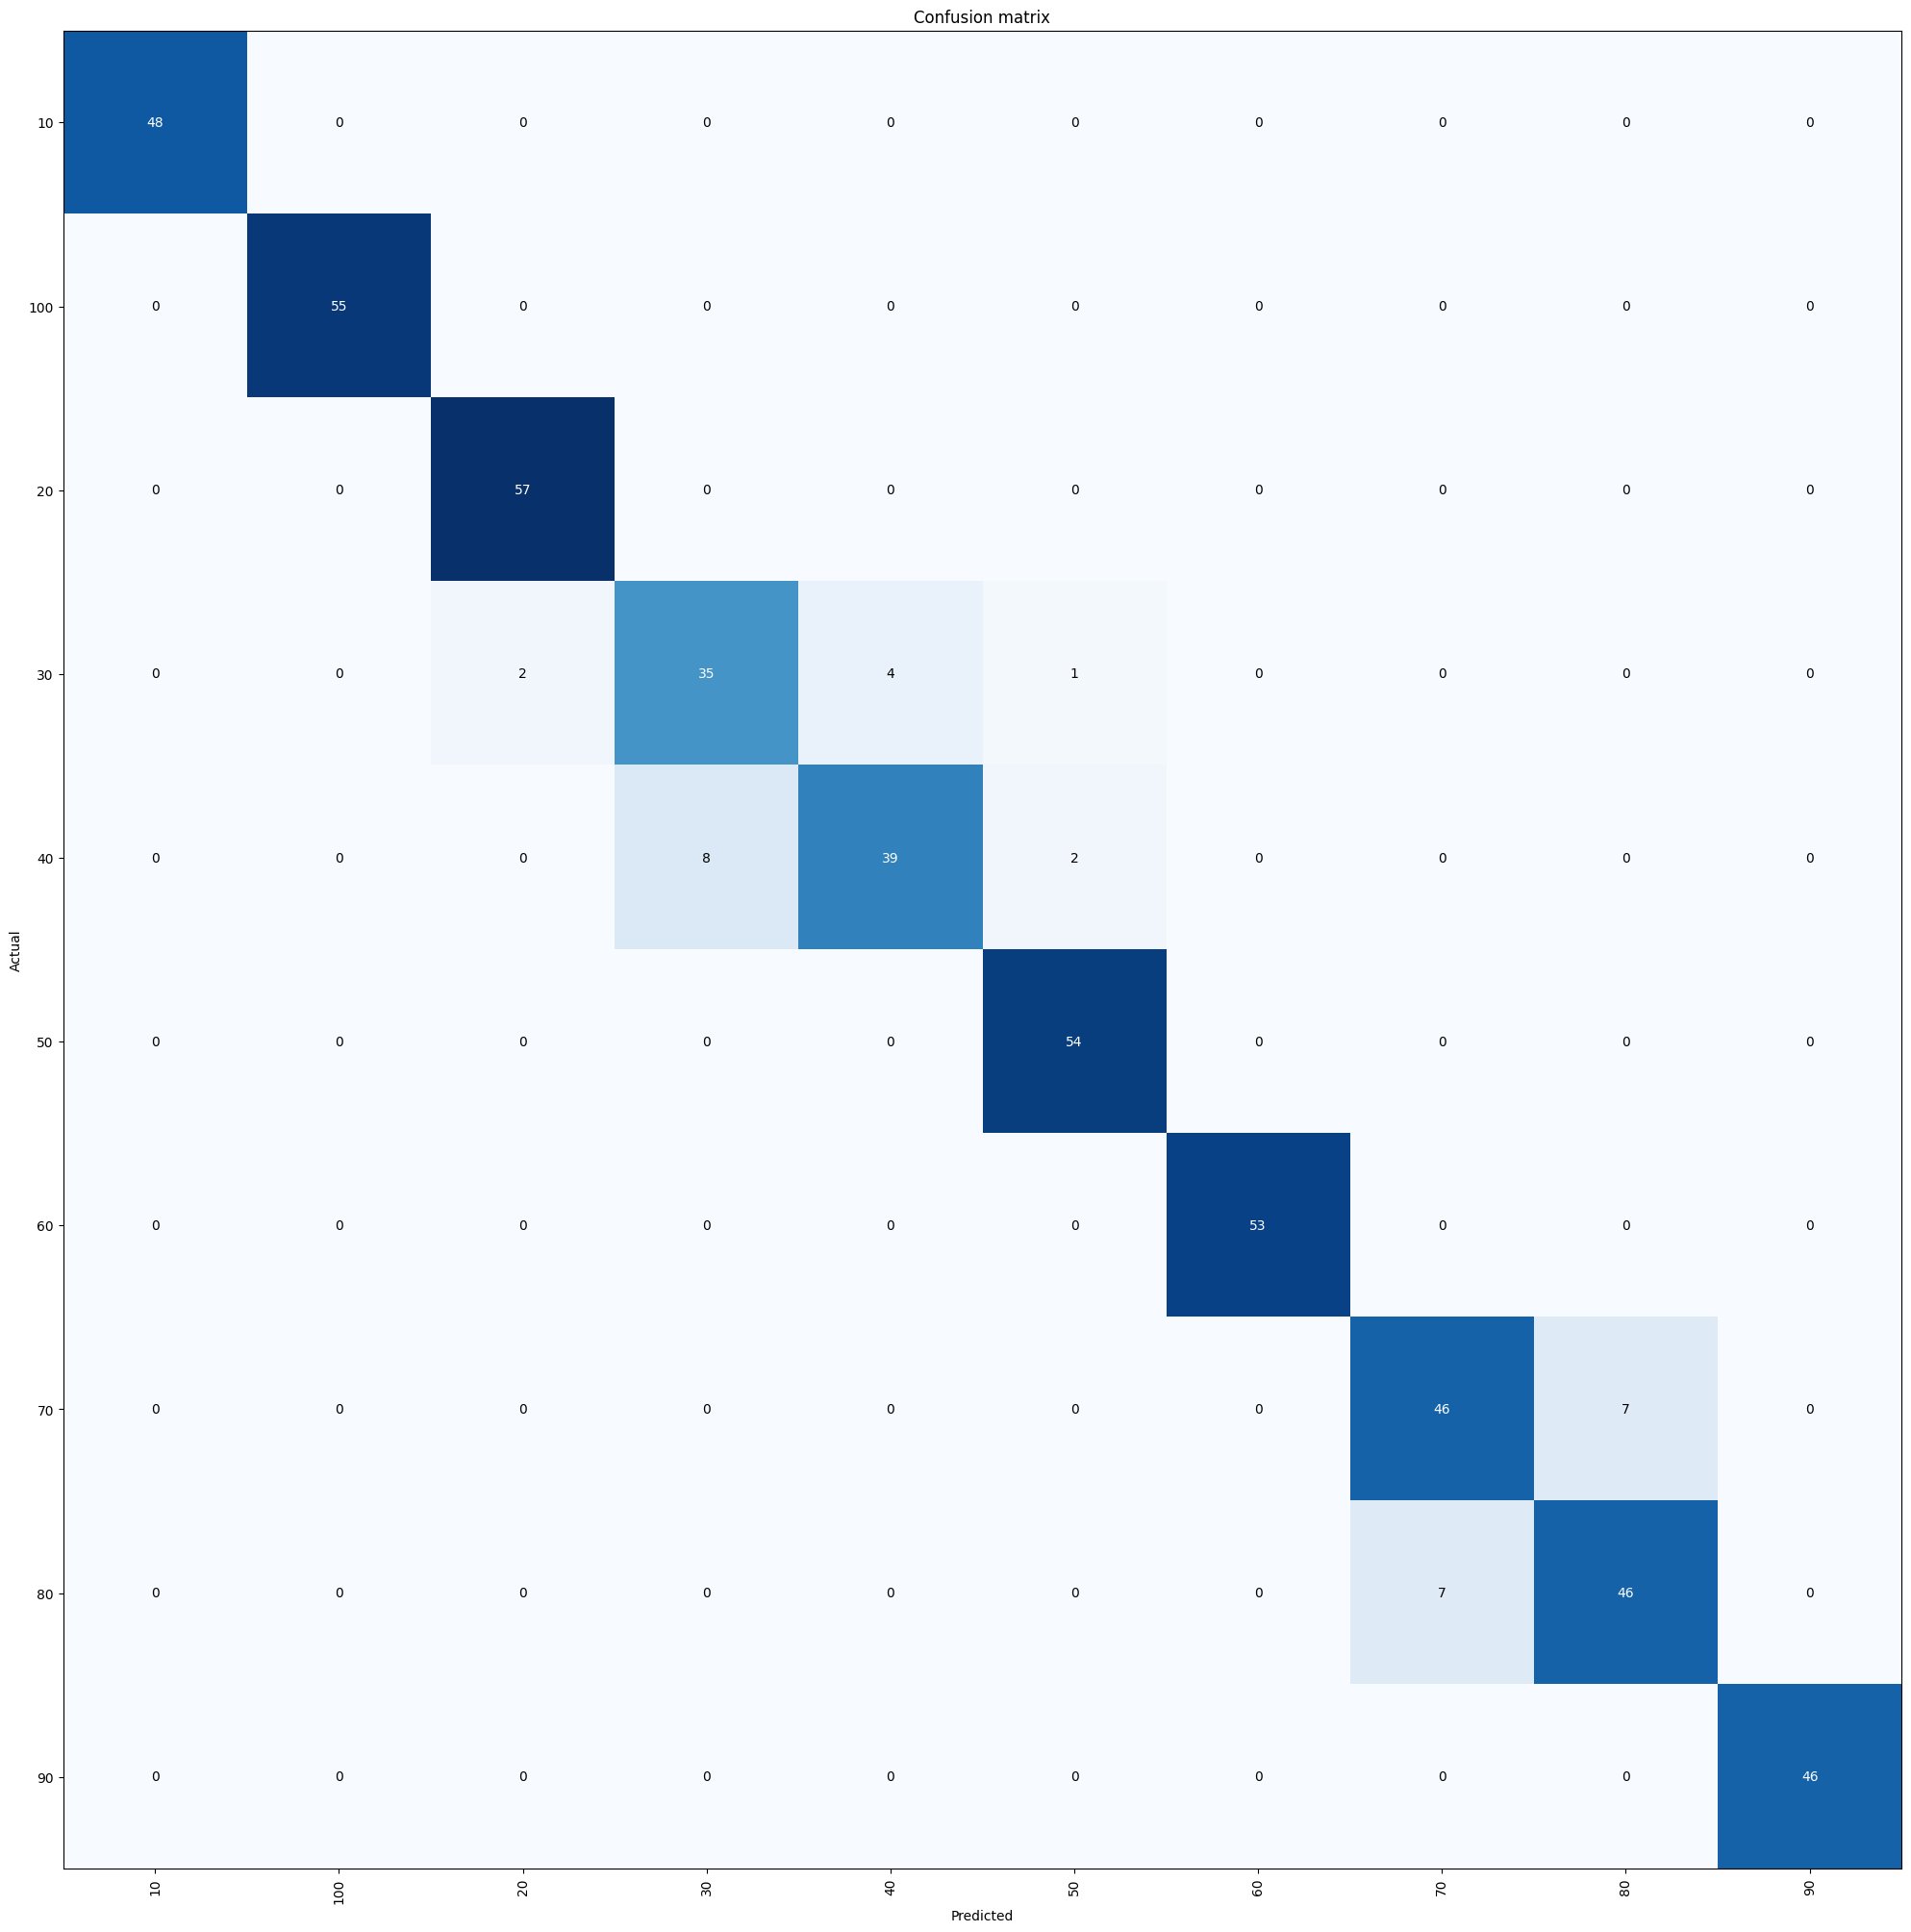

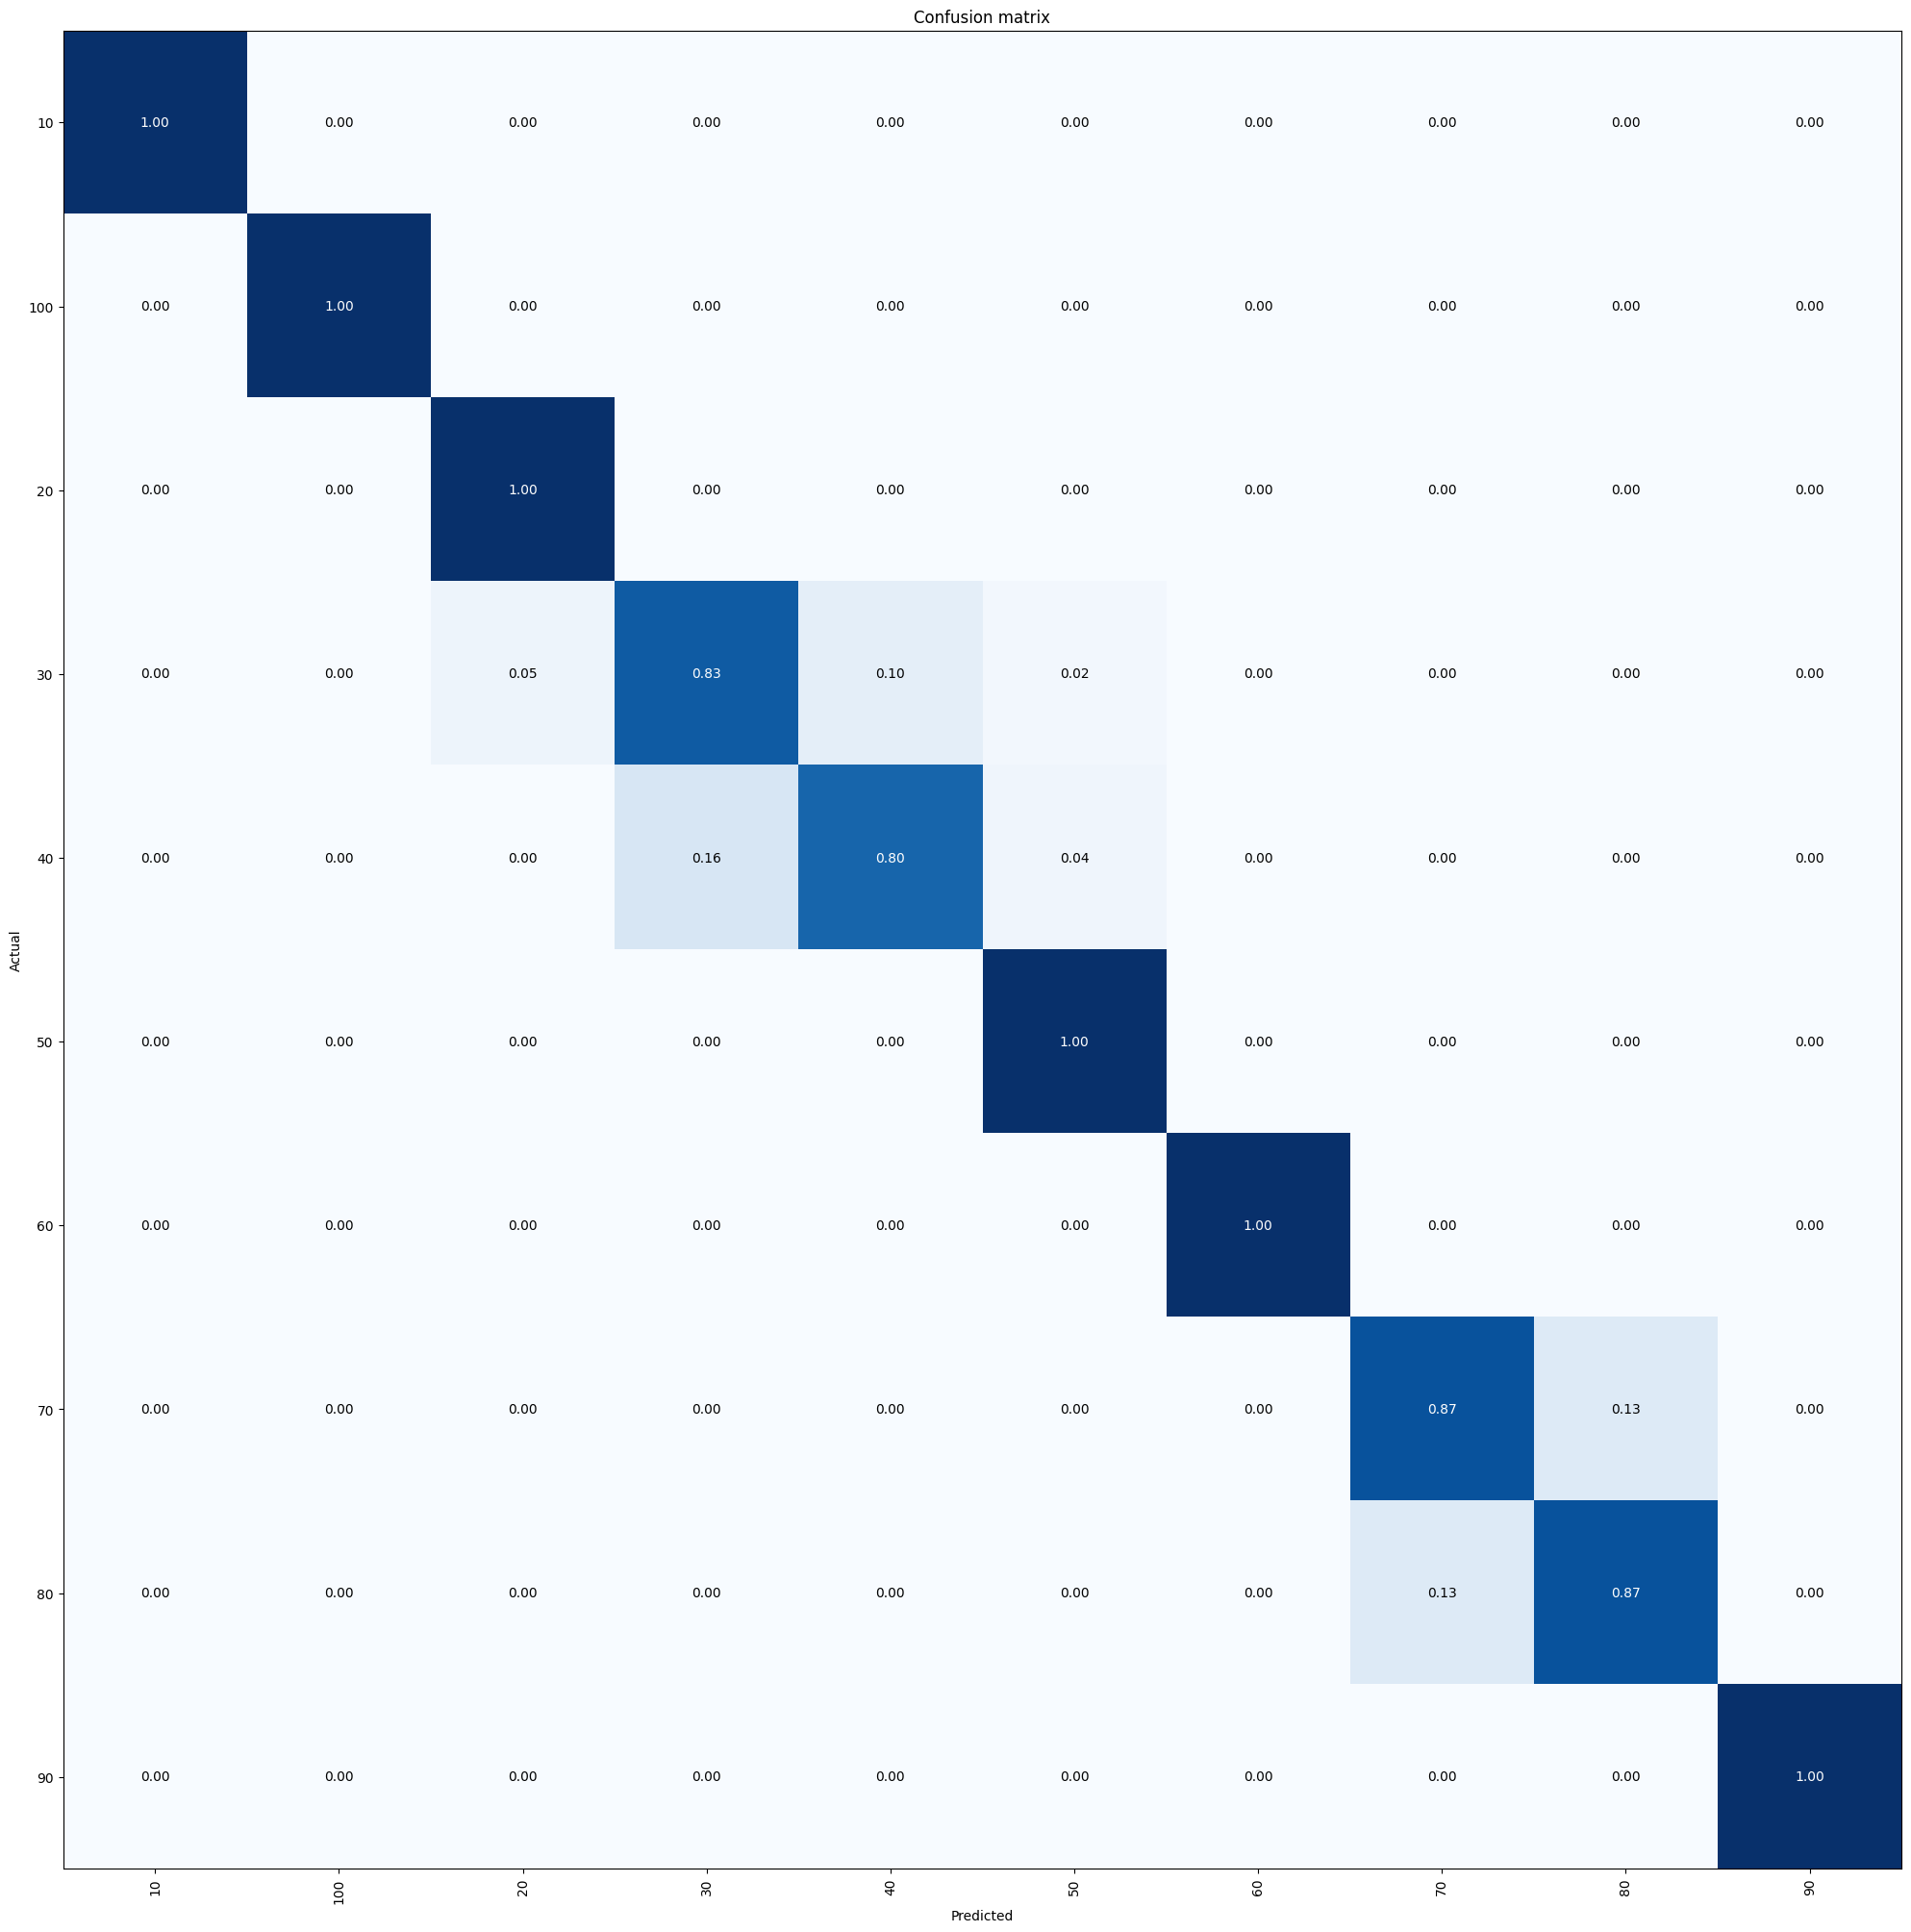

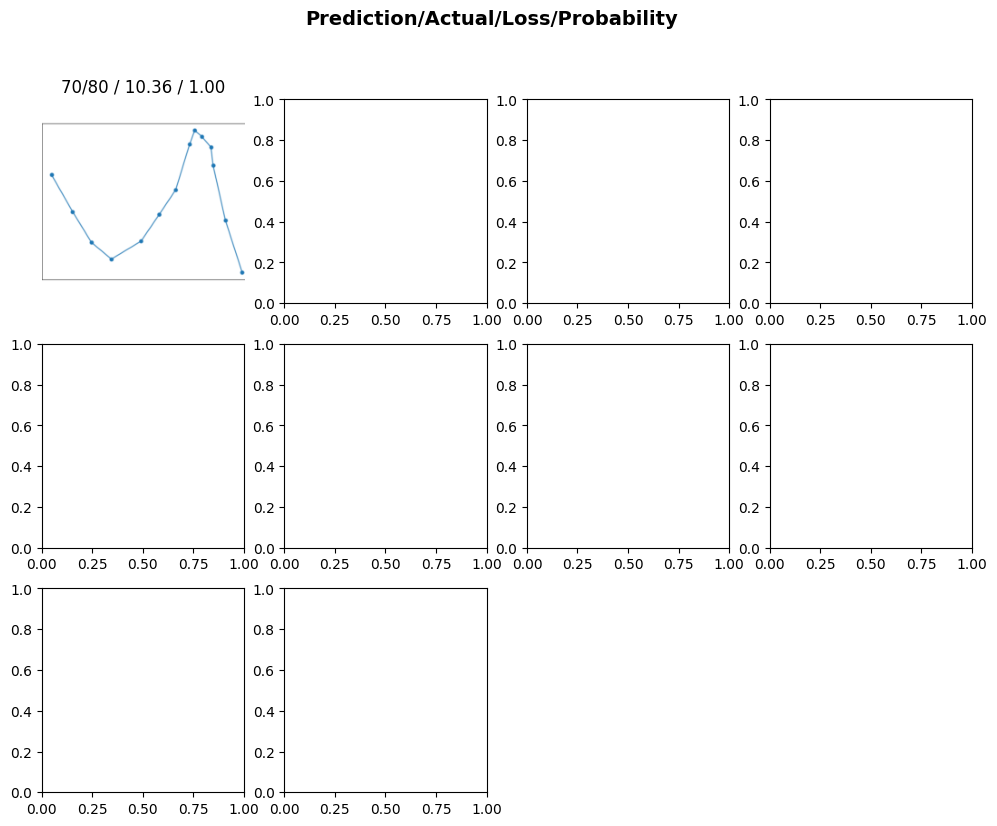

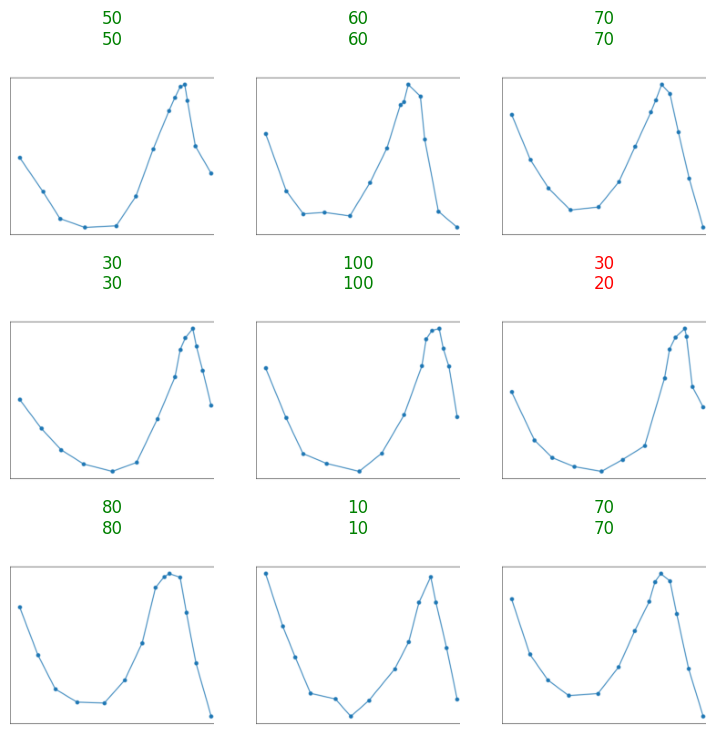

In [19]:
#Store the results here
df_results = pd.DataFrame()
model_accuracy = {}
for experiment_idx, experiment in enumerate(factorial_plan):
    
    print(f'Running experiment {experiment_idx + 1} of {num_experiments}')
    
    predicted_labels = list()
    true_labels = list()
    
    #Compute the patterns
    patterns = get_patterns(meas_table_wide, impedance_col_name,
                            mode = experiment[0].mode, 
                            kwargs = experiment[0].params)
    #Perform data normalisation
    patterns = experiment[1].normalise(patterns)
    data_augmentation_factor=experiment[2]
    
    
    # Train and score model for cross-validation
    #TODO: nel dataset di validazione alcune classi non sono rappresentate. Usare stratified splitter
    config['Splitter'] = RandomSplitter(valid_pct=0.3, seed=41)
    config['rePat'] = r'^.*_(\d+).png$'


    print("battery data acquisitions for training and validation: ")
    print(train_measures_list)
    print("battery data acquisitions for test: ")
    print(test_measures_list)
    experiment_name=experiment_name_prefix+"_Exp_"+str(experiment_idx)
    print("model name: "+experiment_name)

    config['ExperimentName'] = experiment_name
    config['IMAGES_PATH'] = config['root_images_path']+"/"+experiment_name
    config['TEST_IMAGES_PATH'] = config['root_test_images_path']+"/"+experiment_name


    if config['generate_images']:
        train_set_condition = meas_table_wide[(measure_id_col_name)].isin(train_measures_list)
        meas_table_for_training= meas_table_wide[train_set_condition]

        test_set_condition = meas_table_wide[(measure_id_col_name)].isin(test_measures_list)
        meas_table_for_testing= meas_table_wide[test_set_condition]            


        image_generation_record = generate_EIS_images_for_experiment(experiment_name, meas_table_for_training, impedance_col_name,
            soc_col_name, measure_id_col_name, root_image_files_path, 0.0001, experiment_idx, experiment)

        image_generation_record_test = generate_EIS_images_for_experiment(experiment_name, meas_table_for_testing, impedance_col_name,
            soc_col_name, measure_id_col_name, root_image_files_path, 0.0001, experiment_idx, experiment)
    

    # TRAINING
    learn= build_and_train_learner(config,n_epochs=n_epochs)
    #SAVE
    weights_filename=save_model_weights(learn,config["models_path"],experiment_name)
    filename_pth= weights_filename+".pth"
    if IN_COLAB:
        copy_model_to_google_drive(filename_pth,learn.model_dir,config["models_path"])
    # SCORE MODEL
    dl=build_data_loader(config)
    model_accuracy[experiment_name]=score_model(weights_filename,dl,config["models_path"])
        
        
    #Add record to dataframe
    record = pd.DataFrame({
        'Cross_validation_experiment_index' : experiment_idx,
        'Experiment index' : experiment_idx,
        'Feature extraction mode' : experiment[0].mode,
        'Feature normalisation mode' : experiment[1].name,
        'Data augmentation factor' : data_augmentation_factor,
        'Num features' : patterns.shape[1],
        'Model name' : experiment_name,
        'Model accuracy' : model_accuracy[experiment_name],
        'Training images path':config['IMAGES_PATH'],
        'Test images path': config['TEST_IMAGES_PATH']},

        index = [0])
        
    df_results = pd.concat([record, df_results.loc[:]]).reset_index(drop=True)
df_results.to_csv(config['results_path'] + '/'+experiment_name_prefix+'results.csv', index=False)


[[48  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  0  2 35  4  1  0  0  0  0]
 [ 0  0  0  8 39  2  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 46  7  0]
 [ 0  0  0  0  0  0  0  7 46  0]
 [ 0  0  0  0  0  0  0  0  0 46]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.04761905 0.83333333 0.0952381  0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.16326531 0.79591837 0.04081633
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.       

learn.validate()


Model accuracy: 0.94
learn.get_preds()


TensorBase(0.9392)

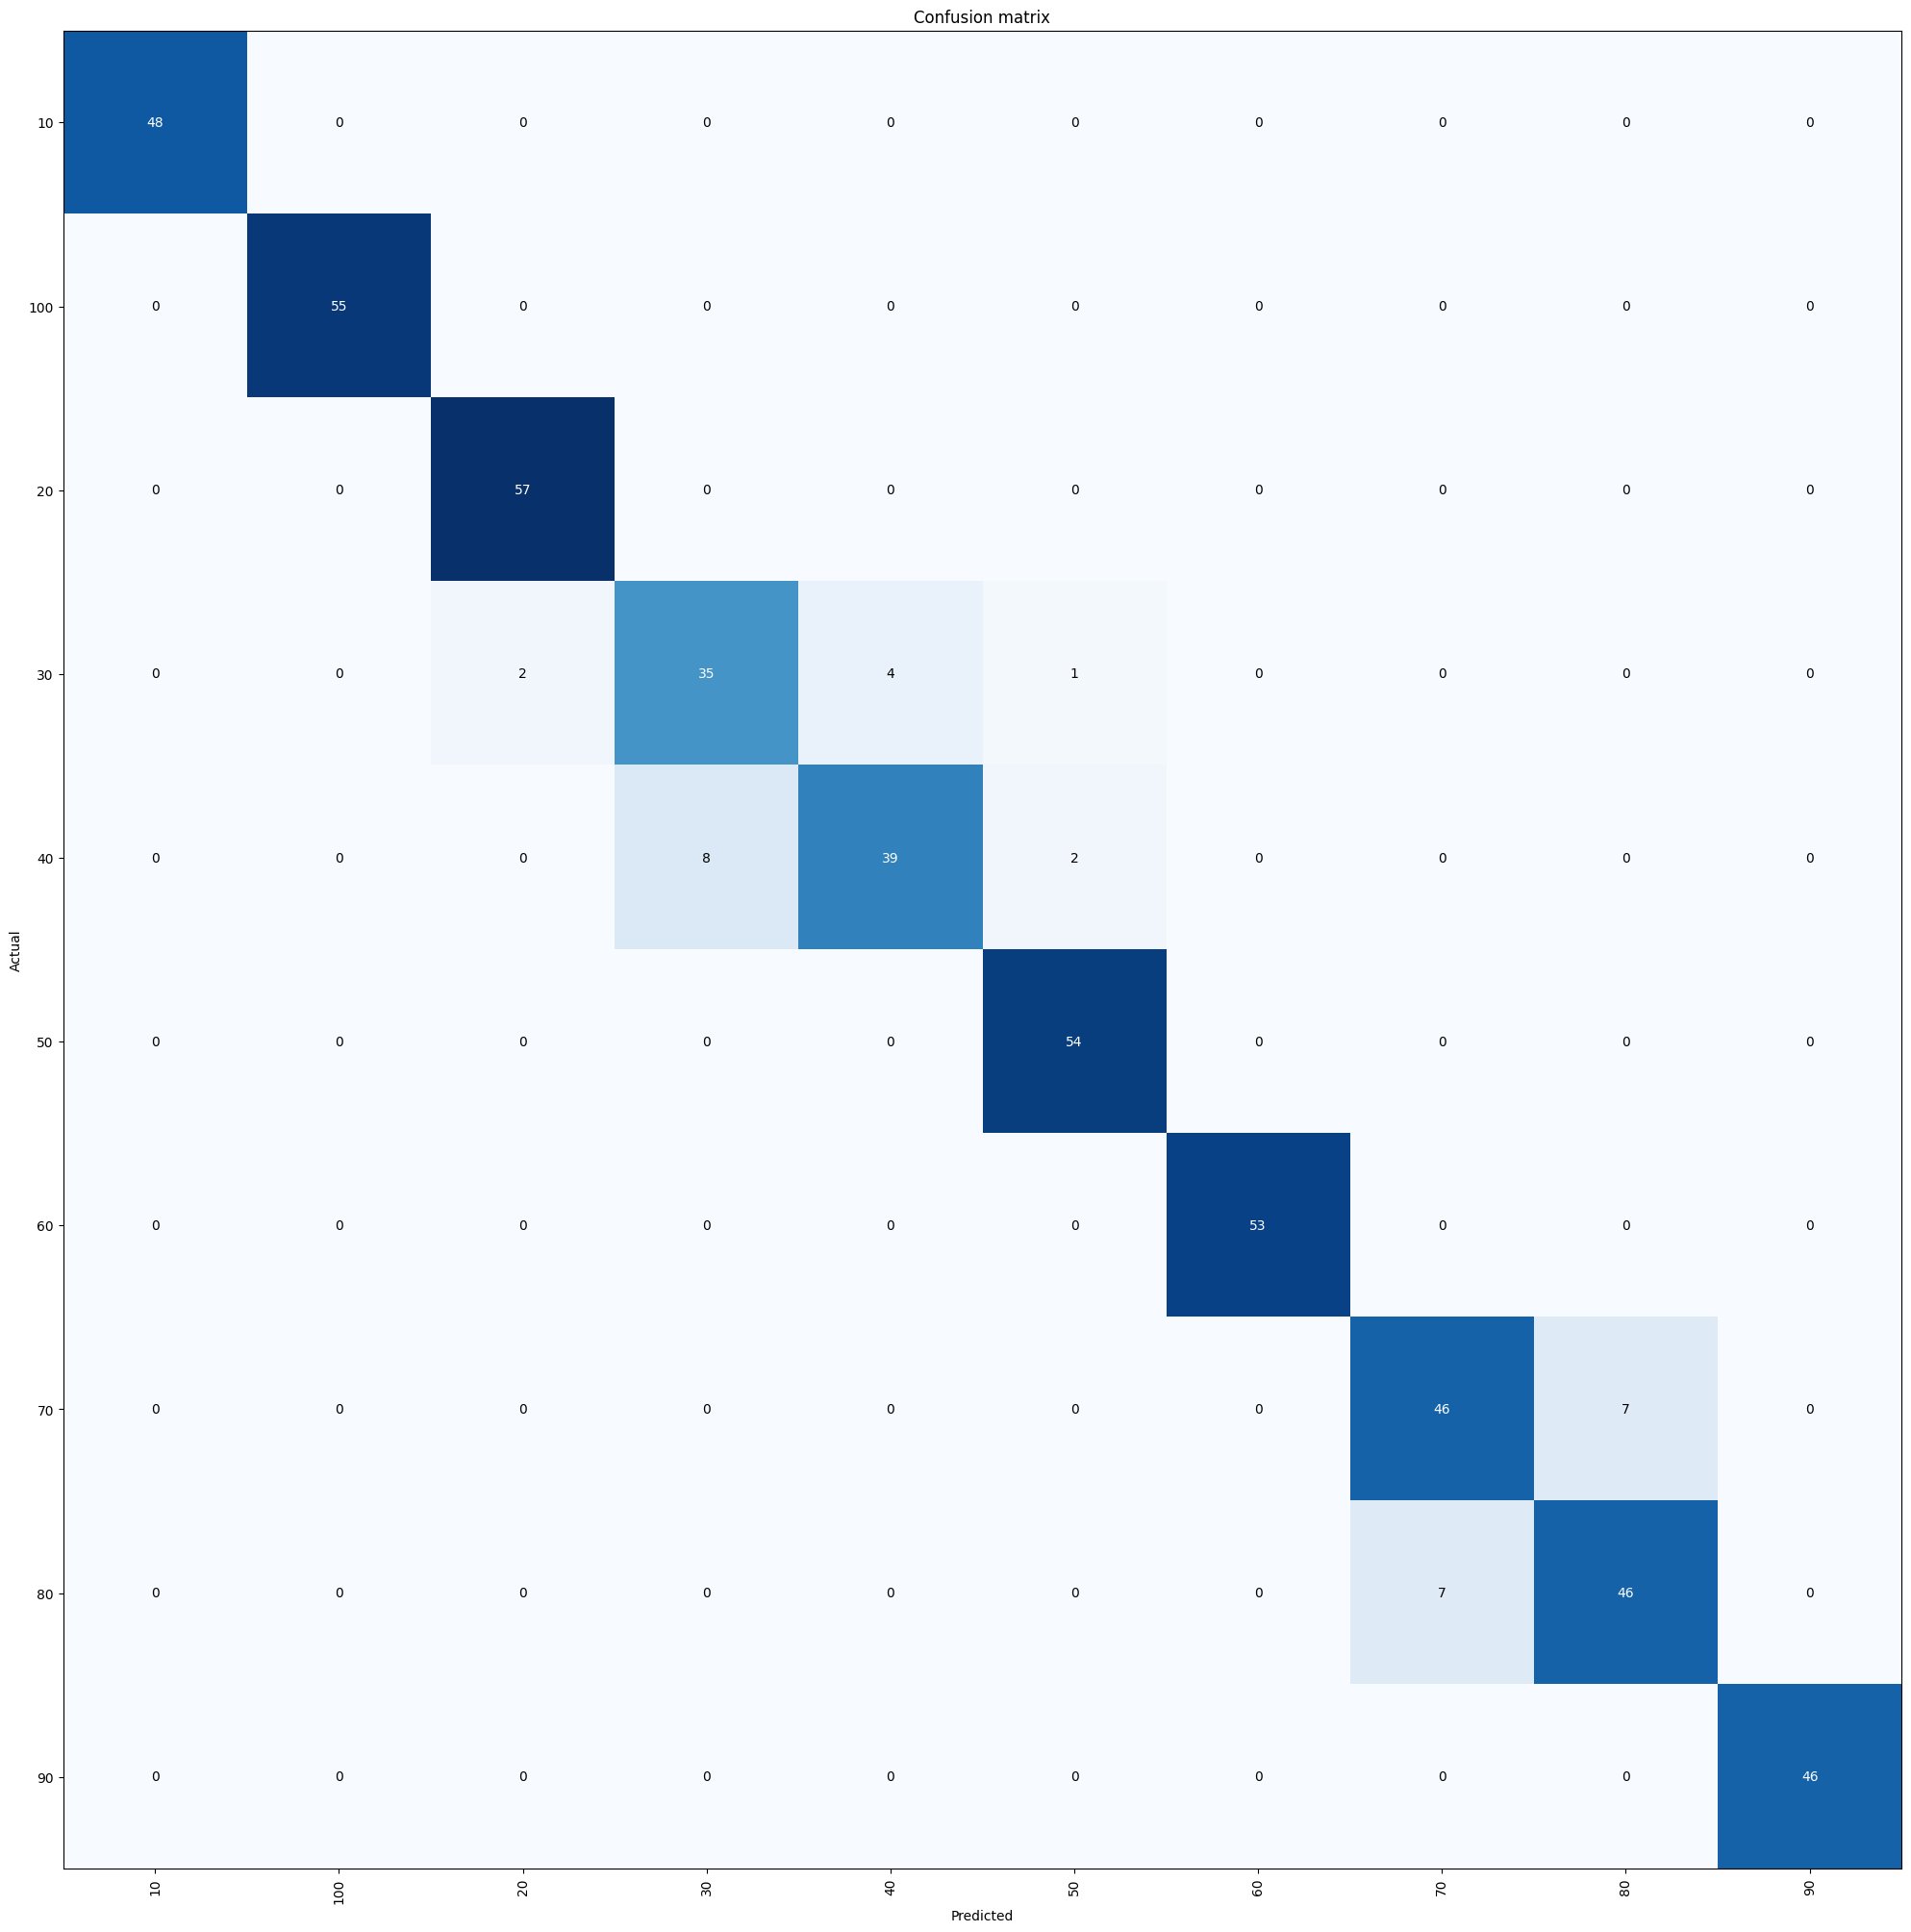

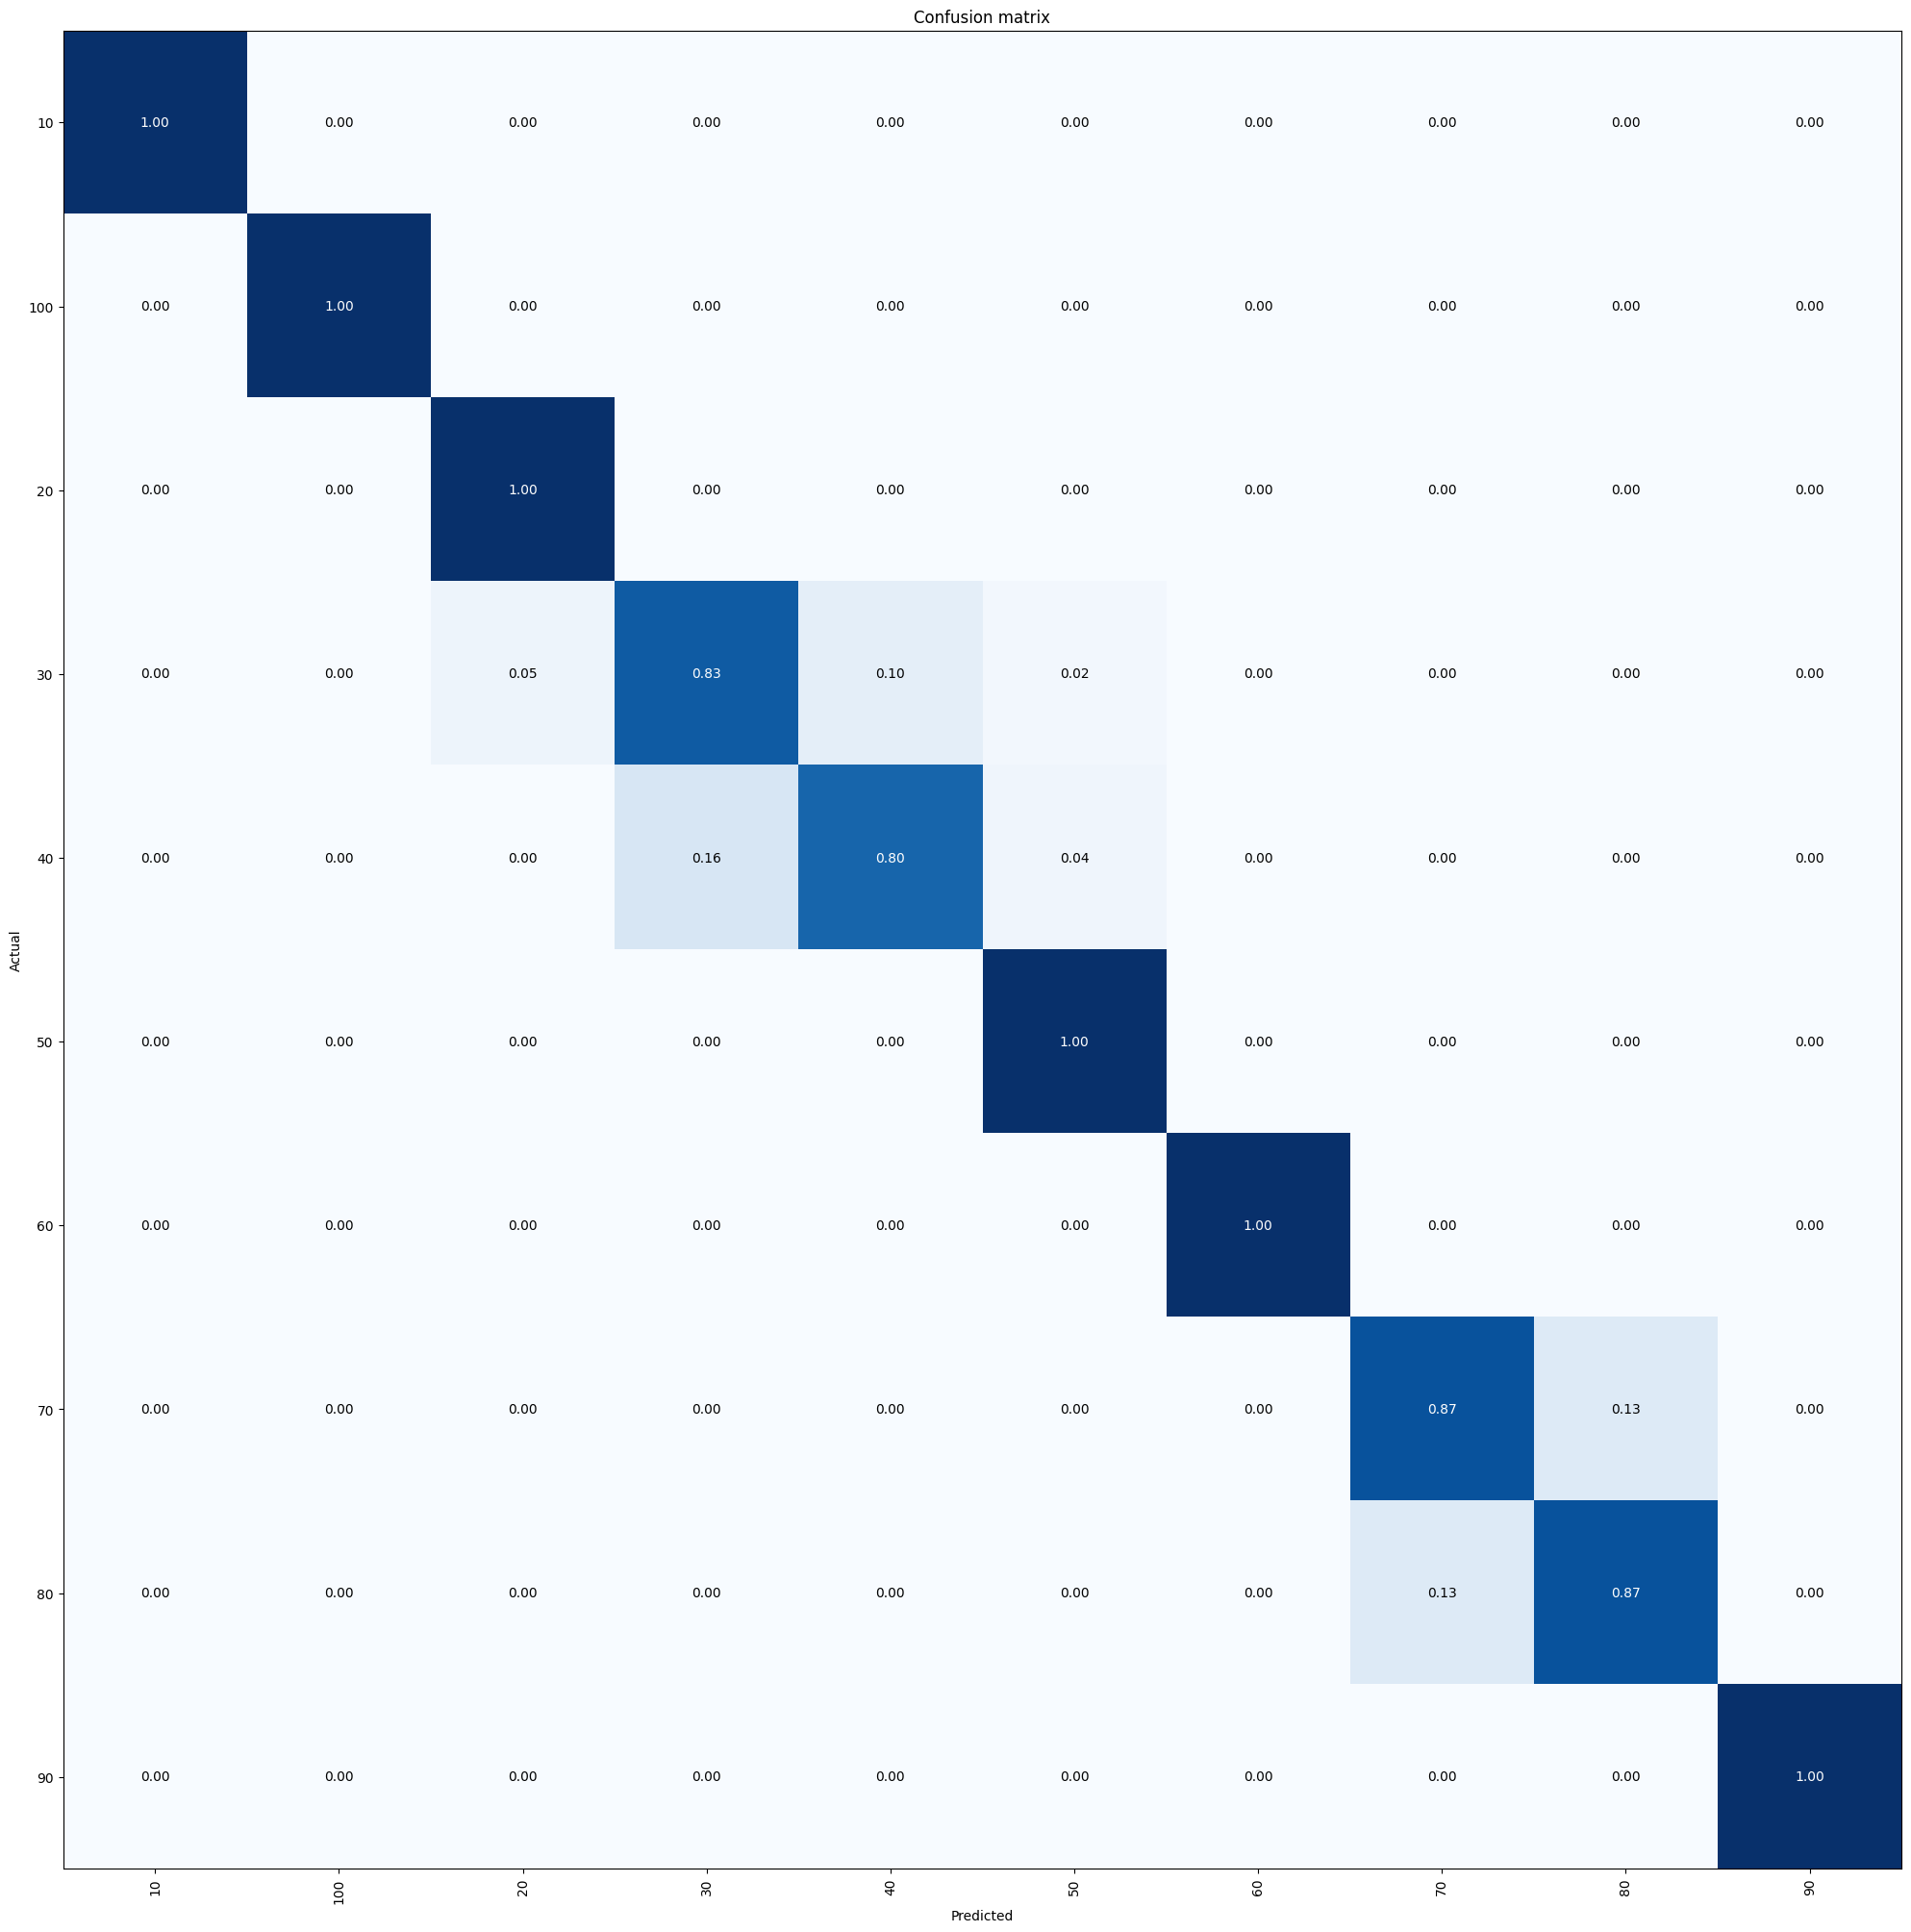

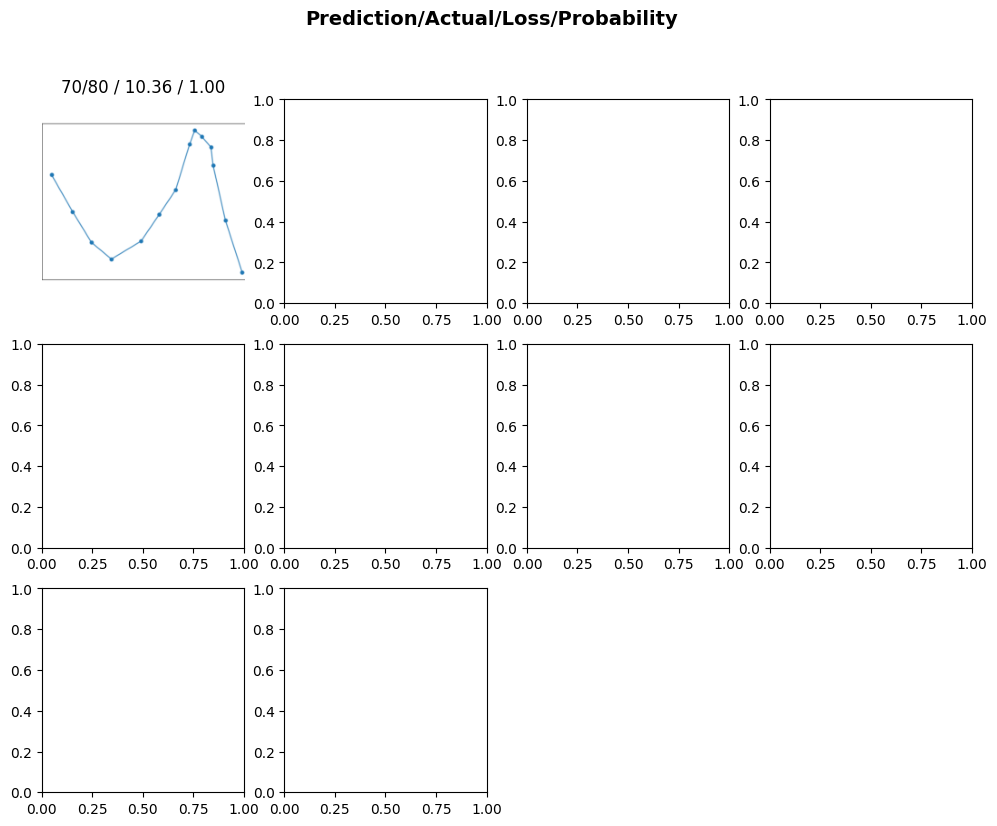

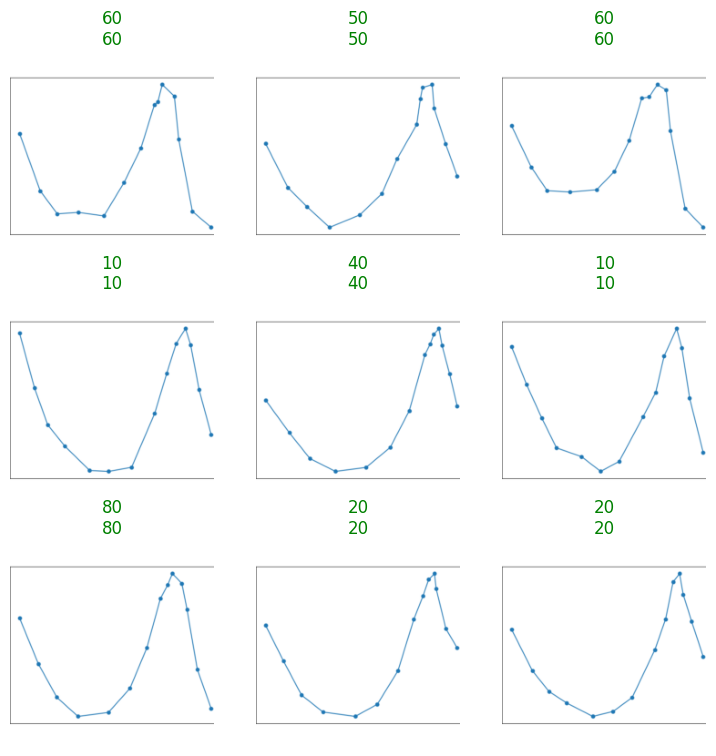

In [20]:
score_model(weights_filename,dl,config["models_path"])

In [21]:
config['IMAGES_PATH']

'../data/images/Paper_MES_v2_single__Exp_1'

In [22]:
df_results

,Cross_validation_experiment_index,Experiment index,Feature extraction mode,Feature normalisation mode,Data augmentation factor,Num features,Model name,Model accuracy,Training images path,Test images path
0,1,1,real+imag,None,10,28,Paper_MES_v2_single__Exp_1,TensorBase(0.9392),../data/images/Paper_MES_v2_single__Exp_1,../data/test_images/Paper_MES_v2_single__Exp_1
1,0,0,bode,None,10,28,Paper_MES_v2_single__Exp_0,TensorBase(0.8843),../data/images/Paper_MES_v2_single__Exp_0,../data/test_images/Paper_MES_v2_single__Exp_0
